In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler


In [3]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

In [4]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [35]:
X_train = train.iloc[:,0:27]
y_train = X_train.pop('RUL')
X_test = test.groupby('unit_nr').last().reset_index()
y_train = y_train.clip(upper=125)

In [6]:
train[index_names].describe()


,unit_nr,time_cycles
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


In [7]:
train[setting_names].describe()


,setting_1,setting_2,setting_3
count,20631.000000,20631.000000,20631.0
mean,-0.000009,0.000002,100.0
std,0.002187,0.000293,0.0
min,-0.008700,-0.000600,100.0
25%,-0.001500,-0.000200,100.0
50%,0.000000,0.000000,100.0
75%,0.001500,0.000300,100.0
max,0.008700,0.000600,100.0


In [8]:
train[sensor_names].describe().transpose()


,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


In [9]:
train.isnull().sum()

unit_nr        0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
RUL            0
dtype: int64

C:\Users\user\AppData\Local\R-MINI~1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Life of Engines')

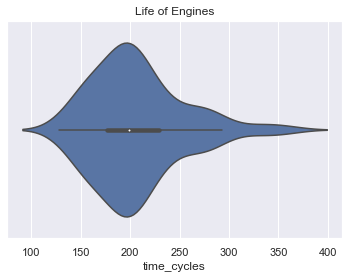

In [10]:
temp_df = train[["unit_nr","time_cycles"]].groupby("unit_nr").max()
sns.violinplot(temp_df.time_cycles)
plt.title("Life of Engines")

In [11]:
train[["unit_nr","time_cycles"]].groupby("unit_nr").max().sort_values(by = ["time_cycles"], ascending= False).head(5)


,time_cycles
unit_nr,
69,362
92,341
96,336
67,313
83,293


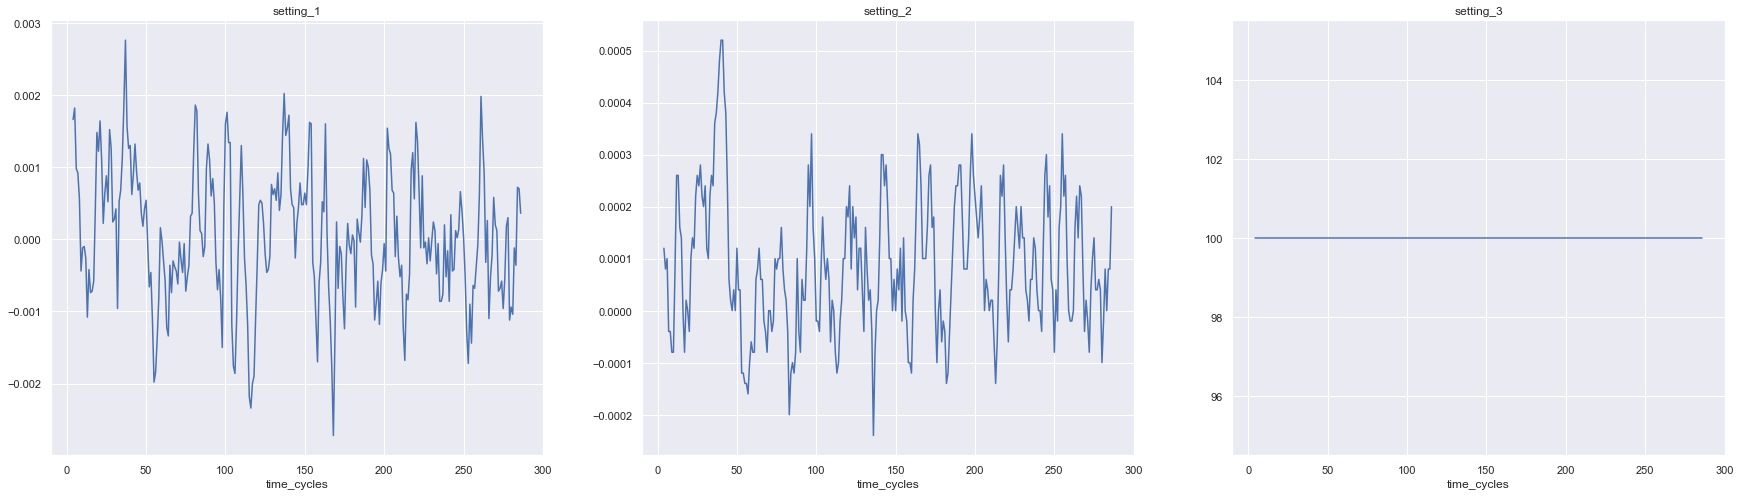

In [12]:
fig,ax=plt.subplots(1,3,figsize=(30,8),sharex='all')
for i in range(0,3):
    df_u1=train.query('unit_nr==2').reset_index(drop = True)
    df_u1['rolling_avg'] = df_u1['setting_'+str(i+1)].rolling(window = 5).mean()
    df_u1['rolling_avg'].plot(kind = "line", ax = ax[i])
    ax[i].set_title('setting_'+str(i+1))
    ax[i].set_xlabel("time_cycles")

In [13]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [14]:
# Scaling
scaler = MinMaxScaler()
scaler.fit(X_train[sensor_names])
X_train_scaled = X_train.copy()
X_train_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_train[sensor_names]), columns=sensor_names)


X_test_scaled = X_test.copy()
X_test_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_test[sensor_names]), columns=sensor_names, index=X_test.index)

In [36]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:19.805441174667326, R2:0.7741261289913107
test set RMSE:22.595554525706564, R2:0.7043441587458725


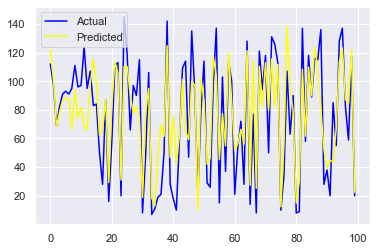

In [37]:
plt.plot(y_test,c='blue',label='Actual')
plt.plot(y_hat_test,c='yellow',label='Predicted')
plt.legend()
plt.show()

In [38]:
svr = SVR(kernel='linear')
svr.fit(X_train, y_train)

# predict and evaluate
y_hat_train1 = svr.predict(X_train)
evaluate(y_train, y_hat_train1, 'train')

y_hat_test1 = svr.predict(X_test)
evaluate(y_test, y_hat_test1)

train set RMSE:27.891978257789557, R2:0.5520231321635365
test set RMSE:31.01060660292726, R2:0.4431208228568526


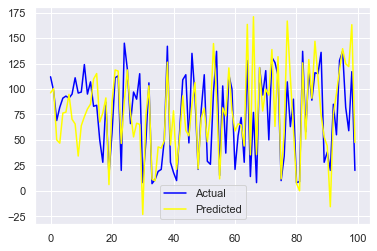

In [39]:
plt.plot(y_test,c='blue',label='Actual')
plt.plot(y_hat_test1,c='yellow',label='Predicted')
plt.legend()
plt.show()

In [40]:
# eventhough we set np and tf seeds, gss requires its own seed
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique(), '\n')
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

split_result = train_val_group_split(X_train, y_train, gss, train['unit_nr'])
X_train_split, y_train_clipped_split, X_val_split, y_val_clipped_split = split_result

train_split_engines [  2   3   4   6   7   8   9  10  12  14  15  16  17  18  20  21  22  24
  25  26  27  28  29  30  33  35  36  37  38  39  41  42  43  44  47  48
  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  72  73  75  76  79  80  82  83  85  86  87  88  89  90  92
  93  94  95  96  97  98  99 100] 

validate_split_engines [ 1  5 11 13 19 23 31 32 34 40 45 46 54 71 74 77 78 81 84 91] 



In [41]:
split_result = train_val_group_split(X_train_scaled, y_train, gss, train['unit_nr'], print_groups=True)
X_train_split_scaled, y_train_clipped_split_scaled, X_val_split_scaled, y_val_clipped_split_scaled = split_result

train_split_engines [  2   3   4   6   7   8   9  10  12  14  15  16  17  18  20  21  22  24
  25  26  27  28  29  30  33  35  36  37  38  39  41  42  43  44  47  48
  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  72  73  75  76  79  80  82  83  85  86  87  88  89  90  92
  93  94  95  96  97  98  99 100] 

validate_split_engines [ 1  5 11 13 19 23 31 32 34 40 45 46 54 71 74 77 78 81 84 91] 



In [42]:
train_cols = setting_names+sensor_names
input_dim = len(train_cols)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [43]:
epochs = 40

history = model.fit(X_train_split_scaled[train_cols], y_train_clipped_split_scaled,
                    validation_data=(X_val_split_scaled[train_cols], y_val_clipped_split_scaled),
                    epochs=epochs)

Epoch 1/40
518/518 [==============================] - 1s 3ms/step - loss: 2018.3398 - val_loss: 1635.4707
Epoch 2/40
518/518 [==============================] - 1s 2ms/step - loss: 1471.1758 - val_loss: 1006.6949
Epoch 3/40
518/518 [==============================] - 1s 2ms/step - loss: 564.6419 - val_loss: 421.2133
Epoch 4/40
518/518 [==============================] - 1s 2ms/step - loss: 462.1584 - val_loss: 394.3302
Epoch 5/40
518/518 [==============================] - 1s 2ms/step - loss: 441.2820 - val_loss: 372.8954
Epoch 6/40
518/518 [==============================] - 1s 2ms/step - loss: 417.6378 - val_loss: 357.0658
Epoch 7/40
518/518 [==============================] - 1s 2ms/step - loss: 406.5426 - val_loss: 349.0359
Epoch 8/40
518/518 [==============================] - 1s 2ms/step - loss: 400.9326 - val_loss: 339.1508
Epoch 9/40
518/518 [==============================] - 1s 2ms/step - loss: 394.9823 - val_loss: 335.9800
Epoch 10/40
518/518 [==============================] - 1s 2m

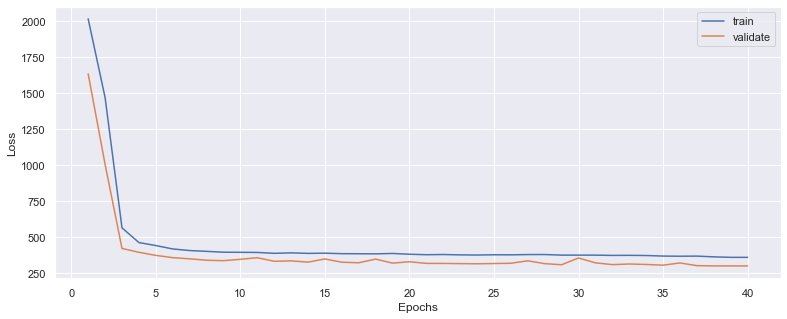

In [44]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [45]:
y_hat_train3 = model.predict(X_train_scaled[train_cols])
evaluate(y_train, y_hat_train3, 'train')

y_hat_test3 = model.predict(X_test_scaled[train_cols])
evaluate(y_test, y_hat_test3)

train set RMSE:18.523518549917146, R2:0.8024195718787583
test set RMSE:19.3712808137503, R2:0.782701299296038


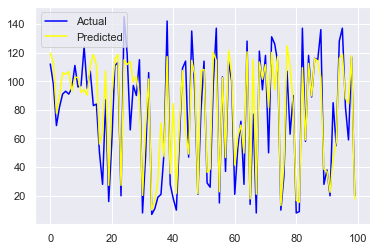

In [46]:
plt.plot(y_test,c='blue',label='Actual')
plt.plot(y_hat_test3,c='yellow',label='Predicted')
plt.legend()
plt.show()